**Objective:** 

In this tutorial we will create a simple two-sphere model and simulate DC Resistivity data for various transmitter-receiver configurations.



In [1]:
from SimPEG import *
import simpegDCIP as DC
import scipy.interpolate as interpolation
import time
import re

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [2]:
%matplotlib notebook
%pylab inline

C:\Users\dominiquef.MIRAGEOSCIENCE\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['linalg']
`%matplotlib` prevents importing * from pylab and numpy


(-200, 200)

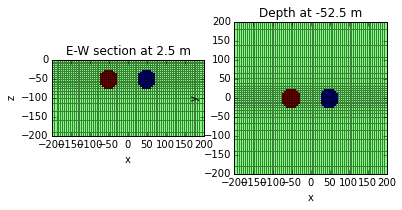

In [13]:
# First we need to create a mesh and a model.

# This is our mesh
dx    = 5.

hxind = [(dx,15,-1.3), (dx, 75), (dx,15,1.3)]
hyind = [(dx,15,-1.3), (dx, 10), (dx,15,1.3)]
hzind = [(dx,15,-1.3),(dx, 15)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCN')

# Define our model
bckgr = 1e-2
cond  = 1e-1
resis = 1e-3
zloc  = -50.
xloc  = 50.
yloc  = 0.
radi  = 25.

# Set background conductivity
model = np.ones(mesh.nC) * bckgr

# First anomaly (conductor)
ind = Utils.ModelBuilder.getIndicesSphere([-xloc,yloc,zloc],radi,mesh.gridCC)
model[ind] = cond

# Second anomaly (resistor)
ind = Utils.ModelBuilder.getIndicesSphere([xloc,yloc,zloc],radi,mesh.gridCC)
model[ind] = resis

# Get index of the center
indy = int(mesh.nCy/2)
indz = int(np.argmin( np.abs(mesh.vectorCCz - zloc) ))

# Plot the model for reference
# Define core mesh extent
xlim = 200
zlim = 200

plt.figure()
ax = plt.subplot(1,2,1, aspect='equal')
mesh.plotSlice(np.log10(model), ax =ax, normal = 'Y', ind = indy,grid=True)
ax.set_title('E-W section at '+str(mesh.vectorCCy[indy])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-xlim,xlim])
plt.ylim([-zlim,0])

ax = plt.subplot(1,2,2, aspect='equal')
mesh.plotSlice(np.log10(model), ax =ax, normal = 'Z', ind = indz,grid=True)
ax.set_title('Depth at '+str(mesh.vectorCCz[indz])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-xlim,xlim])
plt.ylim([-xlim,xlim])

Now that we have model in 3D, we can define a survey.
There area various ground DC configurations used in the field.
We can explore two survey types here: pole-dipole (pdp) and dipole-dipole (dpdp).
In both cases we need to specify three important parameter.

a: Seperation (m) between the transmitter and receivers

b: Dipole seperation (m) of the receiver (and transmitter for dpdp)

n: Number of receiver dipoles along line

We also need to give a starting and end point for the survey.


(-200, 200)

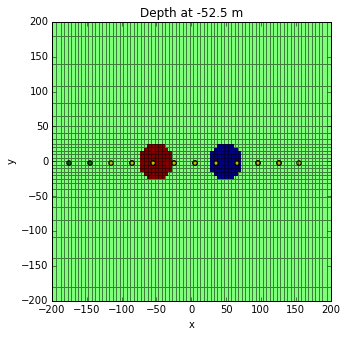

In [14]:
# Survey parameters
a = 30.
b = 30.
n = 20 # Integer number of rx dipoles

# Specify the survey type: "pdp" | "dpdp"
stype = 'dpdp'

# Then specify the end points of the survey. Let's keep it simple for now and survey above the anomalies, top of the mesh
ends = [(-175,0),(175,0)]
ends = np.c_[np.asarray(ends),np.ones(2).T*mesh.vectorNz[-1]]

# Snap the endpoints to the grid. Easier to create 2D section.
indx = Utils.closestPoints(mesh, ends )
locs = np.c_[mesh.gridCC[indx,0],mesh.gridCC[indx,1],np.ones(2).T*mesh.vectorNz[-1]]

# We will handle the geometry of the survey for you and create all the combination of tx-rx along line
[Tx, Rx] = DC.gen_DCIPsurvey(locs, mesh, stype, a, b, n)

# Here is an example for the first tx-rx array
fig, ax = plt.subplots(1,1, figsize = (6.5,5))
mesh.plotSlice(np.log10(model), ax =ax, normal = 'Z', ind = indz,grid=True)
ax.set_title('Depth at '+str(mesh.vectorCCz[indz])+' m')
plt.gca().set_aspect('equal', adjustable='box')

plt.scatter(Tx[0][0,:],Tx[0][1,:],s=20,c='g')
plt.scatter(Rx[0][:,0::3],Rx[0][:,1::3],s=20,c='y')
plt.xlim([-xlim,xlim])
plt.ylim([-xlim,xlim])

The next section will specify all the parameters used to forward model the data

In [16]:
#Set boundary conditions
mesh.setCellGradBC('neumann')

# Define the differential operators needed for the DC problem
Div = mesh.faceDiv
Grad = mesh.cellGrad
Msig = Utils.sdiag(1./(mesh.aveF2CC.T*(1./model)))

A = Div*Msig*Grad

# Change one corner to deal with nullspace
A[0,0] = 1
A = sp.csc_matrix(A)

# We will solve the system iteratively, so a pre-conditioner is helpful
# This is simply a Jacobi preconditioner (inverse of the main diagonal)
dA = A.diagonal()
P = sp.spdiags(1/dA,0,A.shape[0],A.shape[0])
    

In [17]:
# Now we can solve the system for all the transmitters
# We want to store the data
data = []

# There is probably a more elegant way to do this, but we can just for-loop through the transmitters
for ii in range(len(Tx)):
    
    start_time = time.time() # Let's time the calculations
    
    #print("Transmitter %i / %i\r" % (ii+1,len(Tx)))
    
    # Select dipole locations for receiver
    rxloc_M = np.asarray(Rx[ii][:,0:3])
    rxloc_N = np.asarray(Rx[ii][:,3:])
    
    # Number of receivers
    nrx = rxloc_M.shape[0]
  
    # For usual cases "dpdp" or "gradient"
    if not re.match(stype,'pdp'): 
        inds = Utils.closestPoints(mesh, np.asarray(Tx[ii]).T )
        RHS = mesh.getInterpolationMat(np.asarray(Tx[ii]).T, 'CC').T*( [-1,1] / mesh.vol[inds] )   
        
    else: 
        
        # Create an "inifinity" pole
        tx =  np.squeeze(Tx[ii][:,0:1])
        tinf = tx + np.array([dl_x,dl_y,0])*dl_len*2
        inds = Utils.closestPoints(mesh, np.c_[tx,tinf].T)
        RHS = mesh.getInterpolationMat(np.asarray(Tx[ii]).T, 'CC').T*( [-1] / mesh.vol[inds] )  


    # Iterative Solve
    Ainvb = sp.linalg.bicgstab(P*A,P*RHS, tol=1e-5)

    # We now have the potential everywhere
    phi = mkvc(Ainvb[0])
    
    # Solve for phi on pole locations
    P1 = mesh.getInterpolationMat(rxloc_M, 'CC')
    P2 = mesh.getInterpolationMat(rxloc_N, 'CC')
        
    # Compute the potential difference
    dtemp = (P1*phi - P2*phi)*np.pi
    
    data.append( dtemp )     
    print '\rTransmitter {0} of {1} -> Time:{2} sec'.format(ii,len(Tx),time.time()- start_time),
    
print 'Transmitter {0} of {1}'.format(ii,len(Tx))
print 'Forward completed'
 


Transmitter 8 of 9 -> Time:0.990999937057 sec Transmitter 8 of 9
Forward completed


Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

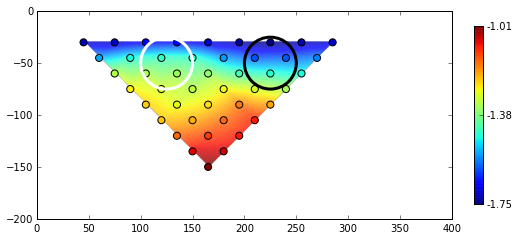

In [25]:
# Let's just convert the 3D format into 2D (distance along line) and plot
[Tx2d, Rx2d] = DC.convertObs_DC3D_to_2D(Tx,Rx)

fig, ax = plt.subplots(1,1, figsize = (8,7))
plt.gca().set_aspect('equal', adjustable='box')

# Plot the location of the spheres for reference
circle1=plt.Circle((-xloc-Tx[0][0,0],zloc),radi,color='w',fill=False, lw=3)
circle2=plt.Circle((xloc-Tx[0][0,0],zloc),radi,color='k',fill=False, lw=3)
ax.add_artist(circle1)
ax.add_artist(circle2)

# Add the speudo section
DC.plot_pseudoSection(Tx2d,Rx2d,data,mesh.vectorNz[-1],stype)

plt.xlim([0,2*xlim])
plt.ylim([-zlim,0])
plt.show()

Back in the days (not so long ago really), geophysicists used to interpret DCR data directly from pseudo-section. Hopefully this example will convince you that interpretating speudo-section is really tricky, arguably impossible.
Fortunately for us, we now have inversion techniques to make sense of the data.

In [24]:
print -xloc-Tx[0][0,0]

125.0
